# AutoBacktest
Given a specific ticker, will return the backtest results of using Facebook Prophet as a trading strategy.

In [223]:
# Libraries
import pandas as pd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import numpy as np
import plotly.express as px
from prophet import Prophet
import yfinance as yf
import itertools
import time

# Get Price Data

In [206]:
def getStockPrices(stock, n_days, training_days, mov_avg):
    """
    Gets stock prices from now to N days ago and training amount will be in addition 
    to the number of days to train.
    """
    
    # Designating the Ticker
    ticker = yf.Ticker(stock)

    # Getting all price history
    prices = ticker.history(period="max")
    
    # Check on length
    if len(prices)<n_days+training_days+mov_avg:
        return pd.DataFrame()
    
    # Getting relevant length
    prices = prices.tail(n_days+training_days+mov_avg)
        
    # Filling NaNs with the most recent values for any missing data
    prices = prices.fillna(method='ffill')
    
    # Getting the N Day Moving Average and rounding the values for some light data preprocessing
    prices['MA'] = prices[['Close']].rolling(
        window=mov_avg
    ).mean().apply(lambda x: round(x, 2))

    # Resetting format for FBP
    prices = prices.reset_index().rename(
        columns={"Date": "ds", "MA": "y"}
    )
    
    # Dropping the Nans
    prices.dropna(inplace=True, subset=['y'])
    
    return prices

In [207]:
def fbpTrainPredict(df, forecast_period):
    """
    Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
    the future based on given forecast period. Returns predicted values as a DF.
    """
    # Setting up prophet
    m = Prophet(
        daily_seasonality=True, 
        yearly_seasonality=True, 
        weekly_seasonality=True
    )
    
    # Fitting to the prices
    m.fit(df[['ds', 'y']])
    
    # Future DF
    future = m.make_future_dataframe(
        periods=forecast_period,
        freq='B',
        include_history=False
    )
            
    # Predicting values
    forecast = m.predict(future)

    # Returning a set of predicted values
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [208]:
def runningFBP(prices, forecast_period, training_days):
    """
    Runs Facebook Prophet to get predictions over a set period 
    of time. Uses FBP to train and predict every N days and gets the 
    price forecasts.
    """
    # DF for the predicted values
    pred_df = pd.DataFrame()

    # Running the model each day
    for i in tqdm(range(training_days, len(prices)+1), leave=False):
        
        # Training and Predicting the last day on the forecast
        forecast = fbpTrainPredict(
            prices[i-training_days:i], 
            forecast_period
        ).tail(1)
        
        # Adding the forecast predicted
        pred_df = pred_df.append(forecast, ignore_index=True)
        
    # Prepping for merge by converting date values to be the same type
    pred_df['ds'] = pred_df['ds'].apply(lambda x: str(x)[:10])

    prices['ds'] = prices['ds'].apply(lambda x: str(x)[:10])
    
    # Shifting the forecasts back in order to compare it to the 'current' open values
    pred_df[['yhat', 'yhat_lower', 'yhat_upper']] = pred_df[['yhat', 'yhat_lower', 'yhat_upper']].shift(-forecast_period)
    
    # Merging with the prices DF in order to compare values for positions later
    merge_df = prices[['ds', 'Open']].merge(
        pred_df,
        on='ds',
        how='outer'
    ).dropna().set_index('ds')

    return merge_df

## Testing Functions

In [173]:
# Pricing Data Parameters
n_days = 31

training_days = 200

forecast_period = 3

mov_avg = 10

# Retrieving prices with the above parameters
prices = getStockPrices(
    "TSLA", 
    n_days=n_days,
    training_days=training_days,
    mov_avg=mov_avg
)

In [174]:
# Running Facebook Prophet with the set parameters
pred_df = runningFBP(
    prices, 
    forecast_period, 
    training_days
)

100%|██████████| 33/33 [00:16<00:00,  2.01it/s]


# Getting Positions

In [175]:
def fbpPositions(pred_df, short=True):
    """
    Gets positions based on the predictions and the actual values.
    """
    if pred_df['Open'] < pred_df['yhat_lower']:
        return 1
    elif pred_df['Open'] > pred_df['yhat_upper'] and short:
        return -1
    else:
        return 0

In [176]:
# Adding sentiment positions to the forecast DF
positions = pred_df

# Getting forecast prophet positions
positions['fbp_positions'] = positions.apply(
    lambda x: fbpPositions(x, short=True), 
    axis=1
)

# Buy and hold position
positions['buy_hold'] = 1

# Backtest

In [177]:
# Getting daily returns
log_returns = prices[['ds', 'Close']].set_index(
    'ds'
).loc[positions.index].apply(np.log).diff()

In [178]:
# The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
bt_positions = positions[[
    'buy_hold', 
    'fbp_positions'
]].shift(1)

# The returns during the backtest
returns = bt_positions.multiply(
    log_returns['Close'], 
    axis=0
)

# Inversing the log returns to get daily portfolio balance
performance = returns.cumsum().apply(
    np.exp
).dropna().fillna(
    method='ffill'
)

# Calculating Backtest Performance

In [188]:
def riskAnalysis(performance):
    """
    Analyzes the performance DataFrame to calculate various
    evaluation metrics on the backtest to determine if
    the backtest performance was favorable.
    """

    # Ending portfolio balance
    bal = performance.tail(1)
    
    # Moving Average returns
    ma_ret = performance.rolling(window=5).mean().dropna()
    
    # Calculating if fbp beats buy and hold on average
    ma_ret['diff'] = ma_ret['fbp_positions'] > ma_ret['buy_hold']
    
    diff = sum(ma_ret['diff'])/len(ma_ret['diff'])

    # Calculating if fbp has positive returns on average
    ma_ret['pos_ret'] = ma_ret['fbp_positions'] > 1
    
    pos_ret = sum(ma_ret['pos_ret']/len(ma_ret['pos_ret']))
    
    # Performance score
    score = 0
    
    # Checking ending portfolio balance
    if bal['fbp_positions'][0]>bal['buy_hold'][0] and bal['fbp_positions'][0]>1: 
        score += 1
    
    # How often fbp outperformed buy and hold
    if diff>.6: 
        score += 1
        
    # How often fbp had positive returns
    if pos_ret>.6: 
        score += 1
        
    # Dictionary containing values
    score_res = {
        "result": True,
        "score": score,
        "endingBalance": {
            "prophet": bal['fbp_positions'][0],
            "buyHold": bal['buy_hold'][0]
        },
        "differenceMovAvgScore": diff,
        "positiveReturns": pos_ret
    }
                
    if score>=3:
                
        return score_res
    
    else:
        # Backtest result is bad
        score_res['result'] = False
        
        return score_res

In [189]:
riskAnalysis(performance)

{'result': True,
 'score': 3,
 'endingBalance': {'prophet': 1.0165492948176589,
  'buyHold': 0.9805809551038082},
 'differenceMovAvgScore': 1.0,
 'positiveReturns': 0.9999999999999996}

# Visualization

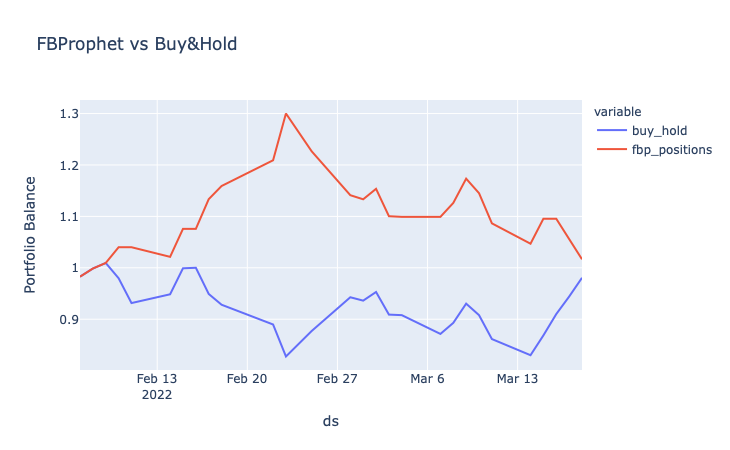

In [183]:
# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='FBProphet vs Buy&Hold',
    labels={"value": "Portfolio Balance",
            "index": "Date"}
)

fig.show()

# Consolidating Backtest Functions

In [193]:
def backtestStock(stock, pred_df, prices, visualize=True):
    
    # Adding positions to the forecast DF
    positions = pred_df

    # Getting forecast prophet positions 
    positions['fbp_positions'] = positions.apply(
        lambda x: fbpPositions(x, short=True), 
        axis=1
    )

    # Buy and hold position
    positions['buy_hold'] = 1
    
    # Getting daily returns
    log_returns = prices[['ds', 'Close']].set_index(
        'ds'
    ).loc[positions.index].apply(np.log).diff()
    
    # The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
    bt_positions = positions[[
        'buy_hold', 
        'fbp_positions'
    ]].shift(1)

    # The returns during the backtest
    returns = bt_positions.multiply(
        log_returns['Close'], 
        axis=0
    )

    # Inversing the log returns to get daily portfolio balance
    performance = returns.cumsum().apply(
        np.exp
    ).dropna().fillna(
        method='ffill'
    )
    
    # Performing risk analysis
    risk = riskAnalysis(performance)
        
    # Printing risk analysis
    print(risk)
    
    # Visualizing results
    if visualize:
        fig = px.line(
            performance,
            x=performance.index,
            y=performance.columns,
            title=f'FBProphet vs Buy&Hold for {stock}',
            labels={"value": "Portfolio Balance",
                    "index": "Date"}
        )

        fig.show()
                
    return risk

# Parameter Tuning

In [209]:
def parameterTuning(stock, n_days_lst, training_days_lst, mov_avg_lst, forecast_period_lst, stop_early=True):
    """
    Given a list of parameters for a specific stock. Iterates through
    different combination of parameters until a successful backtest
    performance is found.
    
    Optional stop_early variable for stopping tuning immediately 
    when a positive backtest result is found
    """
    
    # Tuning the stock with FB Prophet
    print(f"Tuning FBP parameters for {stock}. . .")
    
    # All combinations of the parameters
    params = [n_days_lst, training_days_lst, mov_avg_lst, forecast_period_lst]
    
    lst_params = list(itertools.product(*params))
    
    # List of tested params
    param_lst = []
    
    # Iterating through combos
    for param in tqdm(lst_params):

        # Retrieving prices with the given parameters
        prices = getStockPrices(
            stock, 
            n_days=param[0],
            training_days=param[1], 
            mov_avg=param[2]
        )

        if prices.empty:
            print(f"Not enough price history for {stock}; skipping backtest...")
            continue

        # Running Facebook Prophet with the set parameters
        pred_df = runningFBP(
            prices, 
            forecast_period=param[3], 
            training_days=param[1]
        )

        # Running backtest
        backtest = backtestStock(stock, pred_df, prices, visualize=False)
        
        # Creating param dictionary to record results
        res = {
            "n_days": param[0],
            "training_days": param[1],
            "mov_avg": param[2],
            "forecast_period": param[3],
            "backtestAnalysis": backtest
        }
        
        # Appending the results
        param_lst.append(res)
        
        print(res)
        
        # Checking backtest result
        if backtest['result']==True and stop_early==True:
            return sorted(
                param_lst, 
                key=lambda x: x['result']['endingBalance']['prophet'],
                reverse=True
            )
        
    return sorted(
        param_lst, 
        key=lambda x: x['result']['endingBalance']['prophet'],
        reverse=True
    )

## Tuning Parameters

In [226]:
# Lists of different params to test
n_days_lst = [30, 60]

training_days_lst = [100,200,300]

mov_avg_lst = [3, 5, 10]

forecast_period_lst = [3, 5]


results = parameterTuning(
    "TSLA", 
    n_days_lst, 
    training_days_lst, 
    mov_avg_lst, 
    forecast_period_lst, 
    stop_early=True
)

Tuning FBP parameters for TSLA. . .


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'result': False, 'score': 0, 'endingBalance': {'prophet': 0.896609108663198, 'buyHold': 1.1723255955895715}, 'differenceMovAvgScore': 0.0, 'positiveReturns': 0.0}
{'n_days': 30, 'training_days': 100, 'mov_avg': 3, 'forecast_period': 3, 'backtestAnalysis': {'result': False, 'score': 0, 'endingBalance': {'prophet': 0.896609108663198, 'buyHold': 1.1723255955895715}, 'differenceMovAvgScore': 0.0, 'positiveReturns': 0.0}}


  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [197]:
results

[{'n_days': 30,
  'training_days': 100,
  'mov_avg': 3,
  'forecast_period': 5,
  'result': {'result': False,
   'score': 0,
   'endingBalance': {'prophet': 0.7238384610840178,
    'buyHold': 1.0856744100881184},
   'differenceMovAvgScore': 0.0,
   'positiveReturns': 0.0}},
 {'n_days': 30,
  'training_days': 100,
  'mov_avg': 5,
  'forecast_period': 3,
  'result': {'result': False,
   'score': 0,
   'endingBalance': {'prophet': 0.8060216781672549,
    'buyHold': 1.002805783513278},
   'differenceMovAvgScore': 0.0,
   'positiveReturns': 0.0}},
 {'n_days': 30,
  'training_days': 100,
  'mov_avg': 5,
  'forecast_period': 5,
  'result': {'result': False,
   'score': 0,
   'endingBalance': {'prophet': 0.9021372387898375,
    'buyHold': 1.0872907061909525},
   'differenceMovAvgScore': 0.0,
   'positiveReturns': 0.09523809523809523}},
 {'n_days': 30,
  'training_days': 100,
  'mov_avg': 3,
  'forecast_period': 3,
  'result': {'result': False,
   'score': 1,
   'endingBalance': {'prophet': 0.9

# Getting Stock and Backtest

In [123]:
def getStockAndBacktest(stock, n_days, training_days, mov_avg, forecast_period):
    
    # Printing the stock
    print(f"Backtesting {stock}. . .")

    # Retrieving prices with the given parameters
    prices = getStockPrices(
        stock, 
        n_days=n_days,
        training_days=training_days, 
        mov_avg=mov_avg
    )
    
    if prices.empty:
        print(f"Not enough price history for {stock}; skipping backtest...")
        return
    
    # Running Facebook Prophet with the set parameters
    pred_df = runningFBP(
        prices, 
        forecast_period=forecast_period, 
        training_days=training_days
    )
        
    # Running backtest
    backtest = backtestStock(stock, pred_df, prices)
    
    if backtest['result']:
        print(f"{stock} backtest results were positive!")
        
        # Run Prophet for current prediction
        preds = fbpTrainPredict(
            prices.tail(training_days), 
            forecast_period
        ).tail(1)
        
        preds['Open'] = prices.tail(1)['Open'].values
                
        # Getting forecast prophet positions
        trade_decision = fbpPositions(preds.to_dict('records')[0], short=True)
        
        trade_dict = {
            1 : f"Buy {stock}",
            0 : f"Exit {stock}/Do nothing",
            -1: f"Short {stock}"
        }
        
        print(trade_dict[trade_decision])
                
        return trade_dict[trade_decision]
        
    else:
        print(f"Negative backtest results for {stock}.")
        return 
    

  0%|          | 0/52 [00:00<?, ?it/s]

Backtesting FB. . .


100%|██████████| 52/52 [00:24<00:00,  2.10it/s]


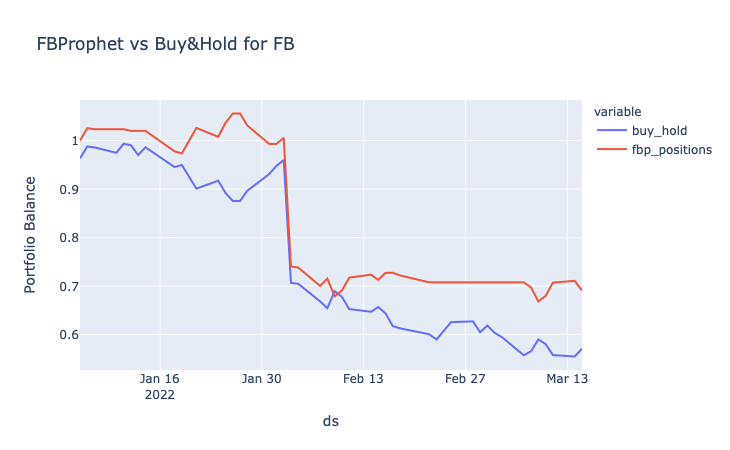

FB backtest results were positive!
Short FB
Backtesting AAPL. . .


 42%|████▏     | 22/52 [00:10<00:14,  2.07it/s]


KeyboardInterrupt: 

In [124]:
for i in ["FB", "AAPL", "NFLX", "AMZN", "GOOG"]:

    getStockAndBacktest(
        stock=i, 
        n_days=50, 
        training_days=100, 
        mov_avg=3,
        forecast_period=3
    )